In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

class ImageDataGenerator(Sequence):
    def __init__(self, color_path, gray_path, batch_size=1):
        self.color_path = color_path
        self.gray_path = gray_path
        self.batch_size = batch_size
        self.image_filenames = os.listdir(color_path)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.array([self.load_image(os.path.join(self.gray_path, filename), is_grayscale=True) for filename in batch_filenames])
        batch_y = np.array([self.load_image(os.path.join(self.color_path, filename)) for filename in batch_filenames])
        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.image_filenames)

    def load_image(self, image_path, is_grayscale=False):
        img = load_img(image_path, target_size=(128, 128), color_mode='grayscale' if is_grayscale else 'rgb')
        img = img_to_array(img).astype(np.float32) / 255.0
        return img

def create_train_val_generators(color_path, gray_path, batch_size=1, val_split=0.2):
    all_filenames = os.listdir(color_path)
    train_filenames, val_filenames = train_test_split(all_filenames, test_size=val_split, random_state=42)

    train_gen = ImageDataGenerator(color_path, gray_path, batch_size)
    train_gen.image_filenames = train_filenames

    val_gen = ImageDataGenerator(color_path, gray_path, batch_size)
    val_gen.image_filenames = val_filenames

    return train_gen, val_gen

# Usage
color_path = 'landscape Images/color'
gray_path = 'landscape Images/gray'

train_generator, val_generator = create_train_val_generators(color_path, gray_path, batch_size=16)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def build_autoencoder():
    inputs = Input(shape=(128, 128, 1))
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(3, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_autoencoder()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_11[0][0]']              
                                )                                                           

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/7
357/357 [==============================] - 82s 230ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 2/7
357/357 [==============================] - 83s 231ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 3/7
357/357 [==============================] - 82s 230ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/7
357/357 [==============================] - 83s 233ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 5/7
357/357 [==============================] - 83s 231ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 6/7
357/357 [==============================] - 82s 229ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 7/7
357/357 [==============================] - 88s 245ms/step - loss: 0.0050 - val_loss: 0.0047


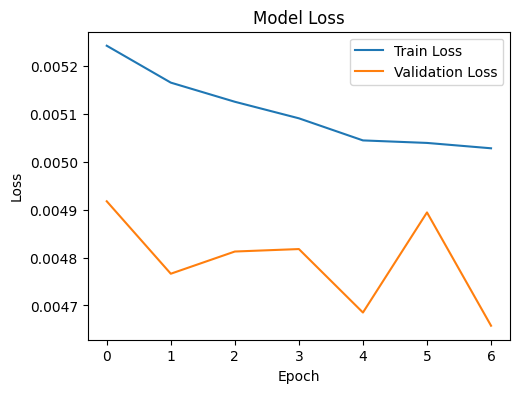

1/1 [==============================] - 0s 30ms/step


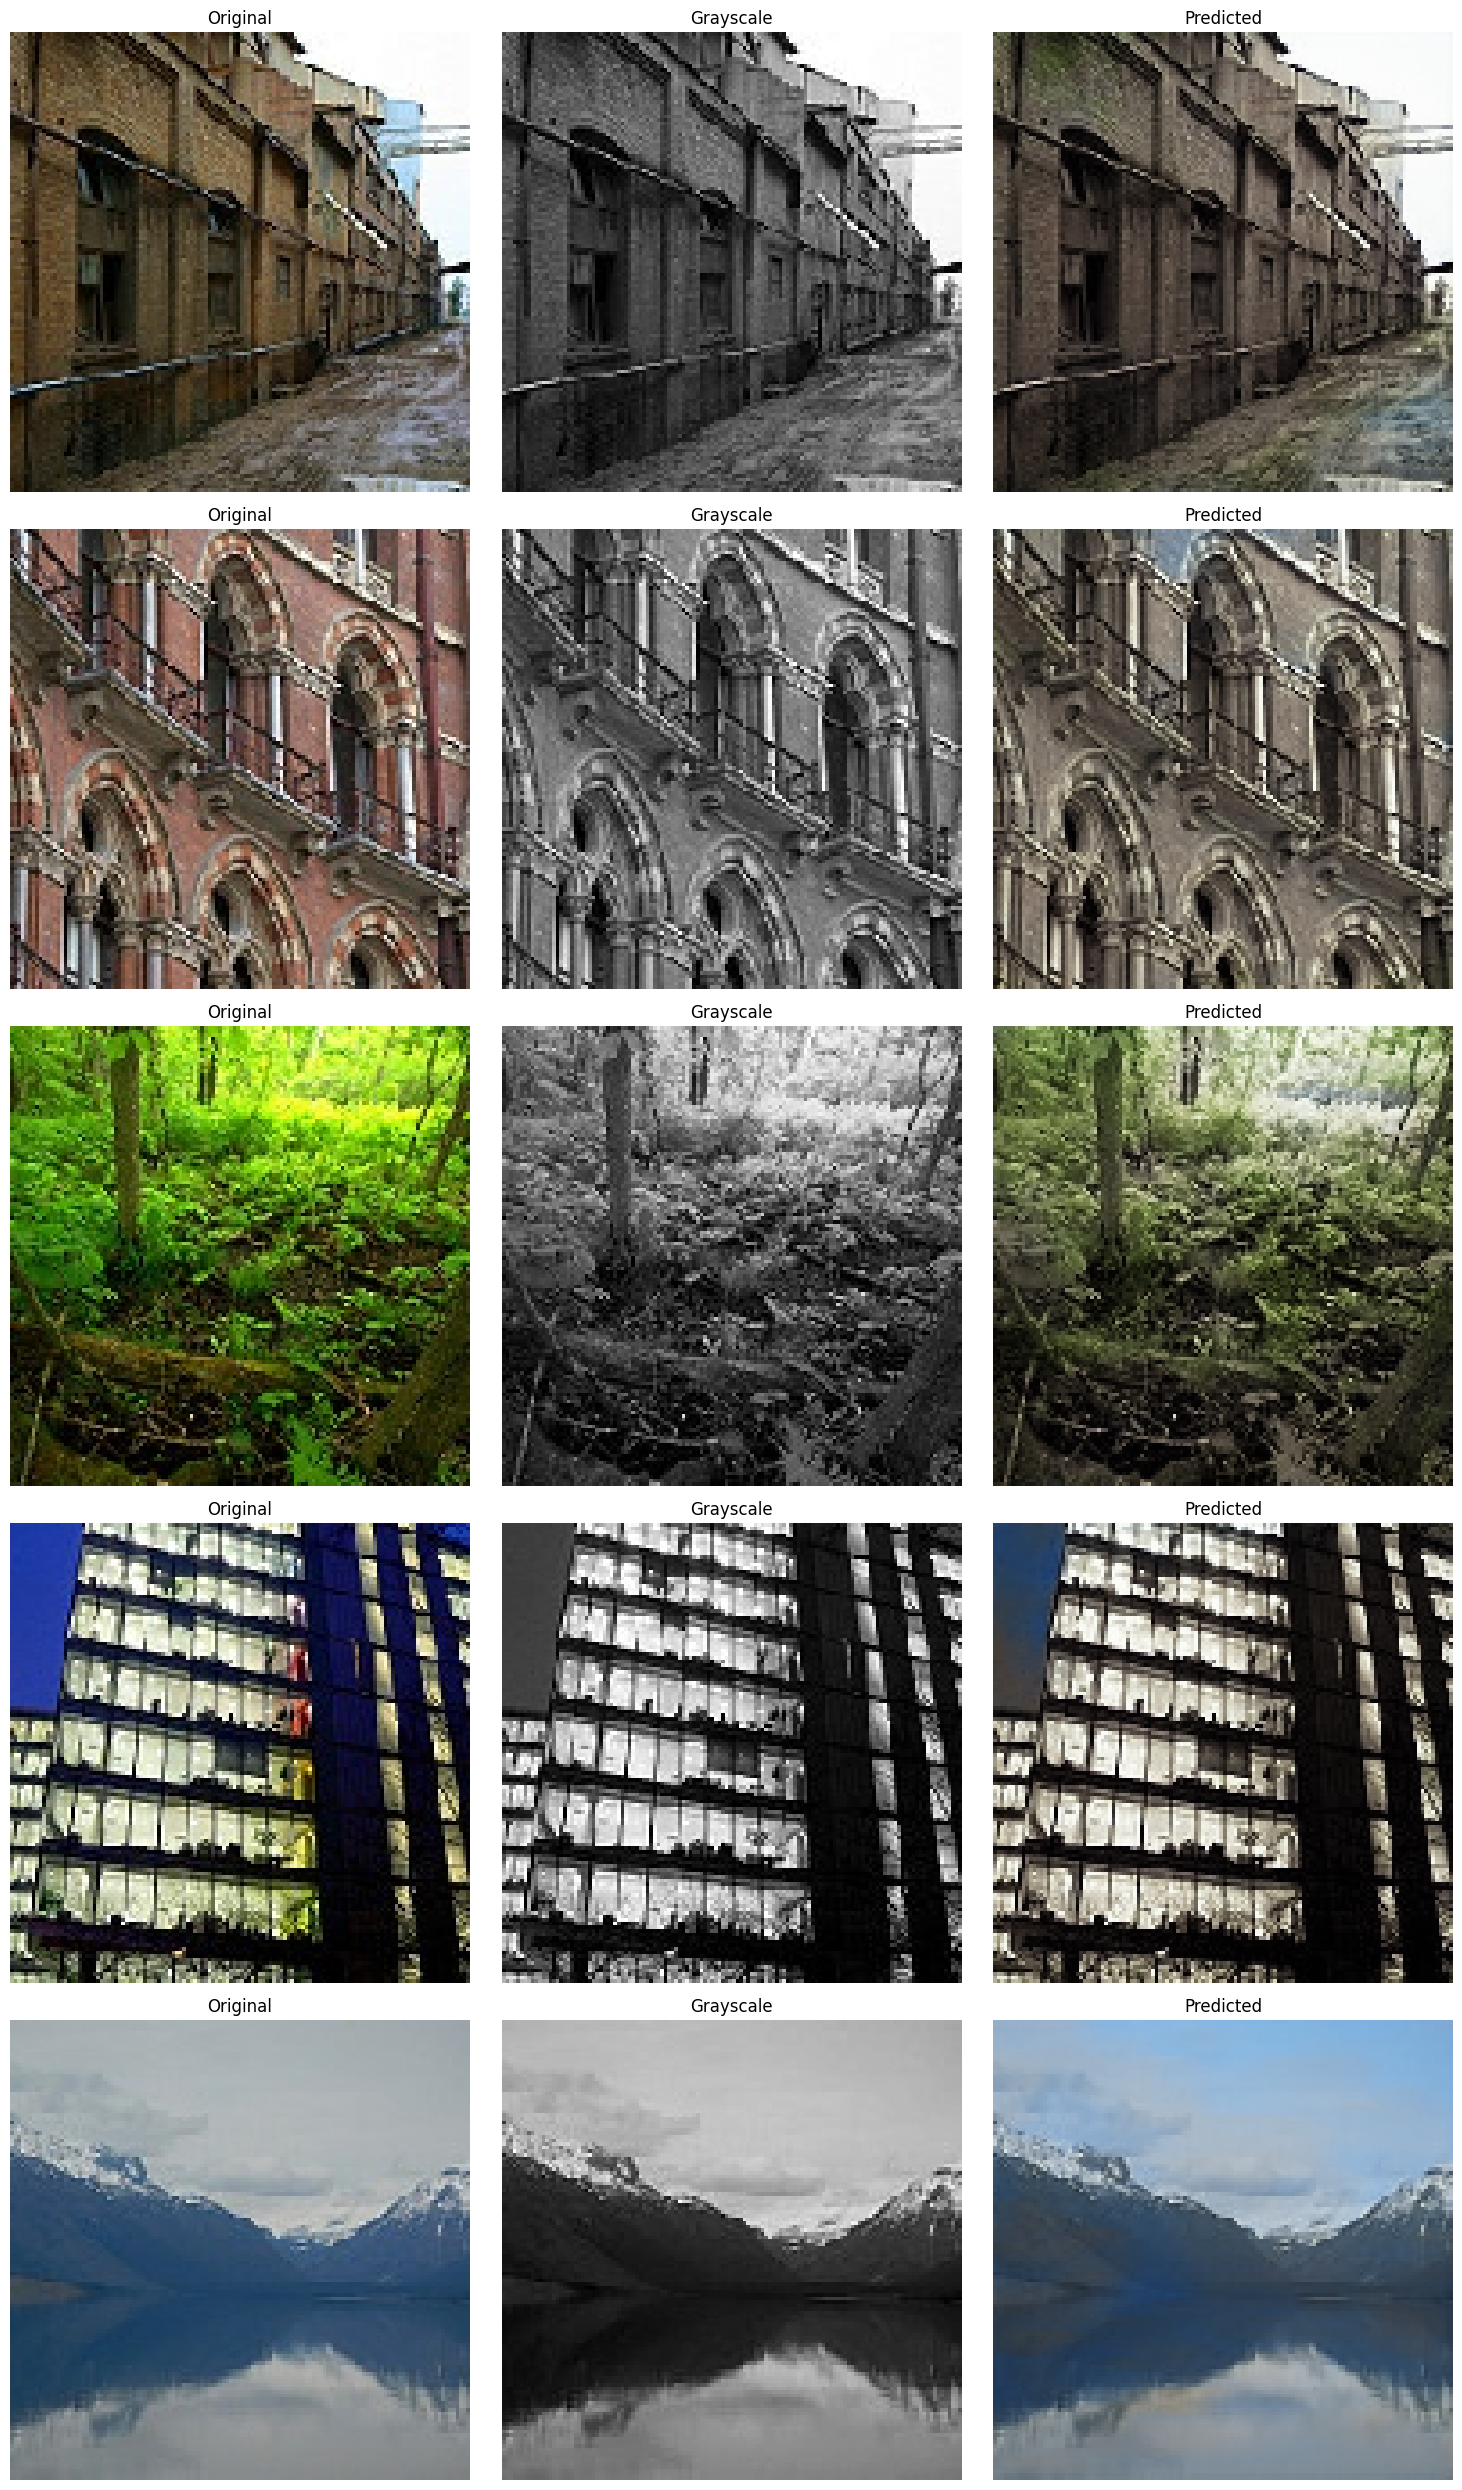

In [11]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize some predictions
def plot_results(original, grayscale, predicted, n=5):
    plt.figure(figsize=(15, 5*n))
    for i in range(n):
        ax = plt.subplot(n, 3, i*3 + 1)
        plt.imshow(original[i])
        ax.set_title("Original")
        ax.axis('off')
        
        ax = plt.subplot(n, 3, i*3 + 2)
        plt.imshow(grayscale[i], cmap='gray')
        ax.set_title("Grayscale")
        ax.axis('off')
        
        ax = plt.subplot(n, 3, i*3 + 3)
        plt.imshow(predicted[i])
        ax.set_title("Predicted")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of validation data
val_batch = next(iter(val_generator))
grayscale_images, original_images = val_batch

# Get predictions
predictions = model.predict(grayscale_images[:5])

# Plot results
plot_results(original_images[:5], grayscale_images[:5], predictions)